# Линейная регрессия и стохастический градиентный спуск

In [1]:
import pandas as pd
import numpy as np

## Предобработка

In [2]:
data = pd.read_csv('advertising.csv') #загрузка данных из .csv файла в датафрейм

In [3]:
data.head() #вывод первых 5-ти строк

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [4]:
X = data[['TV', 'Radio', 'Newspaper']].values 
y = data[['Sales']].values

**Вывод: в данном датасете присутвуют только вещественные числа.  
TV, Radio, Newspaper - независмые признаки (вещественные)      
Sales - целевая переменная (вещественный)**

In [5]:
data.describe() #Статистика

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


In [6]:
means, stds = X.mean(axis=0), X.std(axis=0) #среднее и на стандартное отклонение по столбцам.

In [7]:
X = (X - means) / stds #Нормирование z-score

In [8]:
X = np.hstack([X, np.ones((X.shape[0],1))]) #Вектор из единиц, чтобы не обрабатывать отдельно коэффициент  𝑤0

## Линейная регрессия

In [9]:
def linear_prediction(X, w):
    return np.dot(X,w) #Функция ленийной регрессии 

## Cреднеквадратичная ошибка

$$\Large \frac{1}{\ell}\sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}^2} \rightarrow \min_{w_0, w_1, w_2, w_3},$$
где $x_{i1}, x_{i2}, x_{i3}$ - значения признаков $i$-го объекта, $y_i$ - значение целевого признака $i$-го объекта, $\ell$ - число объектов в обучающей выборке.

In [10]:
def mserror(y, y_pred):
    return np.mean((y - y_pred)**2)

## Нормальное уравнение 
Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.  

$$\Large X^TXw = X^Ty$$  
$$\Large w = {(X^TX)}^{-1}X^Ty$$

In [11]:
def normal_equation(X, y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), y) #Нормальное уравнение

In [12]:
norm_eq_weights = normal_equation(X, y)
print(norm_eq_weights) #Веса, найденные с помощью нормального уравнения

[[ 3.91925365]
 [ 2.79206274]
 [-0.02253861]
 [14.0225    ]]


In [13]:
mserror(y, linear_prediction(X, norm_eq_weights)) #Ошибка прогноза значений Sales в виде линейной модели с весами, найденными с помощью нормального уравнения

2.7841263145109365

На практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.

## Градиентный спуск

Градиентный шаг для весов будет выглядеть следующим образом:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}((w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}) - y_i)}},\ j \in \{1,2,3\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

## Стохастический градиентный спуск

В стохастическом варианте градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:
$$\Large w_0 \leftarrow w_0 - \frac{2\eta}{\ell} {((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)}$$
$$\Large w_j \leftarrow w_j - \frac{2\eta}{\ell} {x_{kj}((w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}) - y_k)},\ j \in \{1,2,3\},$$
где $k$ - случайный индекс, $k \in \{1, \ldots, \ell\}$.

In [14]:
def stochastic_gradient_step(X, y, w, train_i, eta=0.01):
    x_n = X[train_i, :]
    y_n = y[train_i]
    y_pred = np.dot(x_n, w)
    l = X.shape[0]
    return w + (2*eta/l)*(y_n - y_pred)*x_n

In [15]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    weight_dist = np.inf  #Инициализация расстояние между векторами весов на соседних итерациях большим числом. 
    w = w_init  #Инициализируем вектор весов
    errors = [] #Ошибки на каждой итерации
    iter_num = 0  #Счетчик итераций
    np.random.seed(seed) #Псевдослучайные числа(номер объекта, который будет менять веса)
    while weight_dist > min_weight_dist and iter_num < max_iter:
        random_i = np.random.randint(X.shape[0]) #Псевдослучайный индекс объекта обучающей выборки
        new_w = stochastic_gradient_step(X, y, w, random_i, eta) #Обновление вектора весов в направлении градиента
        weight_dist = np.linalg.norm(new_w - w) 
        errors.append(mserror(y, np.dot(X, w)))
        w = new_w 
        iter_num += 1
        
    return w, errors

- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- min_weight_dist - максимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

In [16]:
%%time
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, [0, 0, 0, 0], max_iter=1e5)

CPU times: user 13.9 s, sys: 237 ms, total: 14.1 s
Wall time: 14.8 s


Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'MSE')

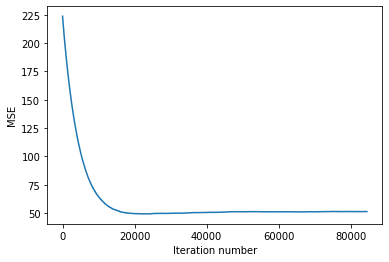

In [17]:
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

**Вывод: алгоритм сходится.**

In [18]:
stoch_grad_desc_weights #Вектор весов, к которому сошелся метод.

array([ 3.91069256e+00,  2.78209808e+00, -8.10462217e-03,  1.40190566e+01])

In [19]:
stoch_errors_by_iter[-1] #Cреднеквадратичная ошибка на последней итерации.

51.29247672273011

In [20]:
mserror(y, linear_prediction(X, stoch_grad_desc_weights).reshape((y.shape[0], 1)))
#Ошибка прогноза значений Sales в виде линейной модели с весами, 
#найденными с помощью стохастического градиентного спуска

2.7844125884067044

**Вывод: Значения функции ошибки при минимазиции нормальныйм уравнением(аналитическое решение(не всегда применимо))   и с помощью стохастического градиентного спуска приблизительно равны, при этом при больших объемах обучающей   выборки минимизация с помощью стохастического спуска опитмальнее по времени при правильном подборе гиперпараметров.**